# Estimating the derivative of the pairwise distance
The goal of this notebook is to estimate how fast the neural representation changes as I move along a morph dimension (i.e. the derivative w.r.t morph distance).

Mathematically, I would like to define categoricality, $C(x): x \in [1, 128]$, such that for a pair of presented stimuli, $a$ and $b$, and a distance, $y$ in neural representation space between these to presentations, 

$y = \int_a^bC(x)dx + \epsilon$

$a,b \in \{p_1, p_2, ... p_n\}$ for some small $n$ and $p_i \in [1, 128]$.
This assumes that the neural representation of these stimuli smoothly vary (up to some noise) as I move along the morph dimension.

I would like to perform a regression on pairs of stimuli presented from the same morph dimension that minimizes the MSE, mean($\epsilon^2$)

I have tried several parameterizations of $C(x)$, however, the constraints I am looking for are:
 1. Strictly positive.
 2. Smooth over the range $[1, 128]$

To keep the function positive I have used $C(x)=e^{f(x)}$
and to keep it smooth I have used $f(x)$ as a polynomial or as different parameterizations of BSplines.

In [1]:
from __future__ import print_function
from __future__ import division
import morphs
from morphs.data.derivative import fit_derivative

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from morphs.data.derivative import f_poly, p0_poly

# def f_poly(x, p, zero_center=True):
#     if zero_center:
#         # 1 -> -1, 128 -> 1
#         x = (2 * x - 129) / 127
#     return np.exp(np.sum([p_i * x ** i for i, p_i in enumerate(p)], axis=0))


# def p0_poly(order, *args):
#     bounds = (-np.inf, np.inf)
#     if len(args) > 0:
#         p_opt = args[0]
#         if len(p_opt) + 1 == order:
#             return np.append(p_opt, [1]), bounds
#     return np.ones(order + 1), bounds

In [3]:
def f_spline_floating(x, p):
    k = 3
    assert (len(p) - 4) % 2 == 0
    n = int((len(p) - 4) / 2) + 4
    c = p[:n]
    t = np.concatenate(([1, 1, 1, 1], np.sort(p[n:]), [128, 128, 128, 128]))
    spl = sp.interpolate.BSpline(t, c, k, extrapolate=False)
    return np.exp(spl(x))


def p0_spline_floating(floating_knots, *args):
    n = 4 + floating_knots
    p0 = np.concatenate((np.ones(n), np.linspace(1, 128, floating_knots + 2)[1:-1]))
    bounds = list(
        zip(*[(-np.inf, np.inf) if i < n else (1, 128) for i in range(len(p0))])
    )
    return p0, bounds

In [4]:
def f_spline_degree(x, p):
    k = len(p) - 1
    t = np.concatenate((np.ones(k + 1), 128 * np.ones(k + 1)))
    c = p
    spl = sp.interpolate.BSpline(t, c, k, extrapolate=False)
    return np.exp(spl(x))


def p0_spline_degree(degree, *args):
    return np.ones(degree + 1), (-np.inf, np.inf)

In [5]:
def f_spline_even(x, p):
    k = 3
    n = len(p)
    t = np.concatenate((np.ones(k), np.linspace(1, 128, n + 1 - k), 128 * np.ones(k)))
    c = p
    spl = sp.interpolate.BSpline(t, c, k, extrapolate=False)
    return np.exp(spl(x))


def p0_spline_even(n, *args):
    return np.ones(n), (-np.inf, np.inf)

In [6]:
def _viz_df_derivative_fits_maker(idxs, p0_func, f, idx_label="index=%d"):
    def _viz_df(**kwargs):
        data = kwargs.pop("data")
        morph_dim = data["morph_dim"].values[0]
        x = np.linspace(1, 128)
        ax = plt.gca()
        popt = np.array([])
        for i in idxs:
            p0, bounds = p0_func(i, popt)
            popt, pcov = fit_derivative(data, p0=p0, bounds=bounds, f=f)
            if not np.isfinite(popt).all():
                break
            ax.plot(x, f(x, popt), label=idx_label % (i))
        psychometric_params = morphs.load.psychometric_params()
        for bsubj in psychometric_params:
            if morph_dim in psychometric_params[bsubj]:
                ax.axvline(
                    psychometric_params[bsubj][morph_dim][3],
                    color=morphs.subj.BEHAVE_COLOR_MAP[bsubj],
                    label=bsubj,
                )

    return _viz_df

In [7]:
def morph_derivative_ordered(
    pair_df, max_order=5, title="", row_order="abcdef", col_order="cdefgh"
):
    _morph_derivative_ordered = _viz_df_derivative_fits_maker(
        range(max_order + 1), p0_poly, f_poly, idx_label="order=%d"
    )
    g = morphs.plot.morph_grid(pair_df, _morph_derivative_ordered, "Categoricality")
    g.set(ylim=(0, 0.04))

In [8]:
def morph_derivative_spline_floating(
    pair_df, max_f_knots=2, title="", row_order="abcdef", col_order="cdefgh"
):
    _morph_derivative_spline_floating = _viz_df_derivative_fits_maker(
        range(max_f_knots + 1),
        p0_spline_floating,
        f_spline_floating,
        idx_label="f_knots=%d",
    )
    g = morphs.plot.morph_grid(pair_df, _morph_derivative_spline_floating, "Categoricality")
    g.set(ylim=(0, 0.04))

In [9]:
def morph_derivative_spline_degree(
    pair_df, title="", row_order="abcdef", col_order="cdefgh", max_degree=2
):
    _morph_derivative_spline_degree = _viz_df_derivative_fits_maker(
        range(max_degree + 1), p0_spline_degree, f_spline_degree, idx_label="degree=%d"
    )
    g = morphs.plot.morph_grid(pair_df, _morph_derivative_spline_degree, "Categoricality")
    g.set(ylim=(0, 0.04))

In [10]:
def morph_derivative_spline_even(
    pair_df, title="", row_order="abcdef", col_order="cdefgh", max_n=7
):
    _morph_derivative_spline_even = _viz_df_derivative_fits_maker(
        range(4, max_n + 1), p0_spline_even, f_spline_even, idx_label="n=%d"
    )
    g = morphs.plot.morph_grid(pair_df, _morph_derivative_spline_even, "Categoricality")
    g.set(ylim=(0, 0.04))

In [11]:
pair_df = morphs.load.pop_pair_df()

In [12]:
morphs.data.parse.morph_dim(pair_df)

In [13]:
for i, (block_path, block_group) in enumerate(pair_df.groupby("block_path")):
    for morph_dim, morph_dim_group in block_group.groupby("morph_dim"):
        print(len(morph_dim_group))
        break
    break

19900


### Can popt be used to initialize next fit?

In [14]:
popt = np.array([])
for order in range(8):
    popt, pcov = fit_derivative(morph_dim_group, p0=np.append(popt, [1]))
    print(popt)

[-4.77880298]
[-4.84760345  0.70617335]
[-4.12547335  2.01763728 -5.00063519]
[-4.02343267  1.68735589 -7.24059024  3.8773089 ]
[-4.03946732  2.44777977 -8.06153915 -1.60437698  6.4492306 ]
[-4.02955811  2.36364615 -8.46178993 -0.26830323  7.02979692 -1.67769592]
[-4.03381201  2.24375971 -7.95815803  1.09008593  3.21701811 -3.04962694
  3.77843128]
[-5.06333399e+00 -4.98710854e-02  1.43654934e+02 -6.62634618e+01
 -2.91699638e+03  4.59745808e+03  2.42285574e+03 -4.88866122e+03]


In [15]:
for f_knots in range(3):
    p0, bounds = p0_spline_floating(f_knots)
    popt, pcov = fit_derivative(
        morph_dim_group, p0=p0, bounds=bounds, f=f_spline_floating
    )
    print(popt)

[-16.82864396   1.70492089  -4.92473967  -5.69936605]
[-8.5302822  -8.12206252 -0.54381505 -6.35549745 -4.90591462 76.2016864 ]
[ -4.3422693  -11.01233329  -6.17250352  -1.88703479  -6.1782424
  -4.99206015  21.61714675  78.61649195]


In [16]:
for degree in range(5):
    popt, pcov = fit_derivative(
        morph_dim_group, p0=np.ones(degree + 1), f=f_spline_degree
    )
    print(popt)

[-4.77880298]
[-5.55380742 -4.14141248]
[-11.14372923   0.87514572  -7.10846056]
[-16.82864396   1.70492089  -4.92473967  -5.69936605]
[ -6.49533636 -12.51457103   5.09677949  -8.46253474  -4.80839321]


In [17]:
for n in range(4, 7):
    popt, pcov = fit_derivative(morph_dim_group, p0=np.ones(n), f=f_spline_even)
    print(popt)

[-16.82864396   1.70492089  -4.92473967  -5.69936605]
[-6.81578228 -9.24117478 -0.43934248 -5.95045112 -5.26593865]
[ -5.53496365 -10.26360083  -4.39339057  -3.1268703   -6.1447774
  -4.93098115]


### Timing Tests

In [18]:
# NBVAL_SKIP
for dim in range(8):
    %timeit fit_derivative(morph_dim_group, p0=np.ones(dim + 1))

878 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.13 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.85 s ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.75 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.81 s ± 870 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.81 s ± 815 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 s ± 55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# NBVAL_SKIP
popt = np.array([])
for dim in range(8):
    %timeit fit_derivative(morph_dim_group, p0=np.append(popt, 1))
    popt, pcov = fit_derivative(morph_dim_group, p0=np.append(popt, 1))

946 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
803 ms ± 51.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.22 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.77 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.95 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.03 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.55 s ± 690 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
# NBVAL_SKIP
for f_knots in range(3):
    p0, bounds = p0_spline_floating(f_knots)
    %timeit fit_derivative(morph_dim_group, p0=p0, bounds=bounds, f=f_spline_floating)

6.16 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.2 s ± 1.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
# NBVAL_SKIP
for degree in range(3):
    %timeit fit_derivative(morph_dim_group, p0=np.ones(degree + 1), f=f_spline_degree)

2.19 s ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.73 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.86 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# NBVAL_SKIP
for n in range(4, 8):
    %timeit fit_derivative(morph_dim_group, p0=np.ones(n), f=f_spline_even)

7.8 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.64 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.5 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
26.4 s ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Single dimension fits with legend

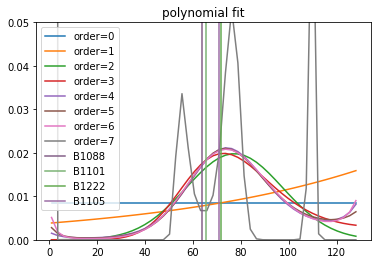

In [23]:
max_order=7
_morph_derivative_ordered = _viz_df_derivative_fits_maker(range(max_order + 1), p0_poly, f_poly, idx_label="order=%d")

_morph_derivative_ordered(data=morph_dim_group)
plt.legend()
plt.ylim(0, .05);
plt.title("polynomial fit");

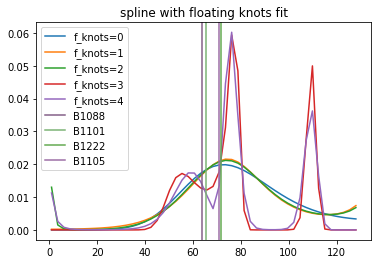

In [24]:
# NBVAL_SKIP
max_f_knots = 4
_morph_derivative_spline_floating = _viz_df_derivative_fits_maker(range(max_f_knots + 1), p0_spline_floating, f_spline_floating, idx_label="f_knots=%d")
_morph_derivative_spline_floating(data=morph_dim_group, max_f_knots=3)
plt.legend();
plt.title("spline with floating knots fit");

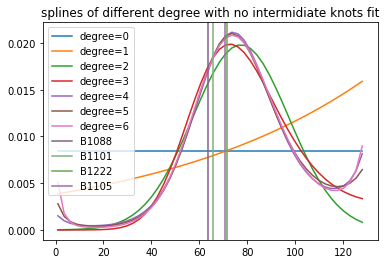

In [25]:
max_degree=6
_morph_derivative_spline_degree = _viz_df_derivative_fits_maker(range(max_degree + 1), p0_spline_degree, f_spline_degree, idx_label="degree=%d")
_morph_derivative_spline_degree(data=morph_dim_group)
plt.legend();
plt.title("splines of different degree with no intermidiate knots fit");

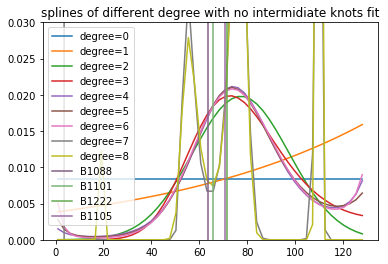

In [26]:
max_degree=8
_morph_derivative_spline_degree = _viz_df_derivative_fits_maker(range(max_degree + 1), p0_spline_degree, f_spline_degree, idx_label="degree=%d")
_morph_derivative_spline_degree(data=morph_dim_group)
plt.legend();
plt.ylim(0, .03);
plt.title("splines of different degree with no intermidiate knots fit");

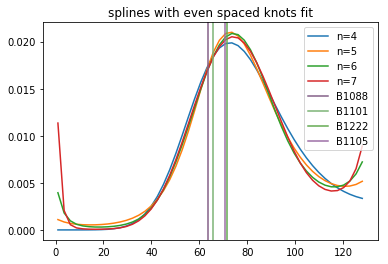

In [27]:
max_n = 7
_morph_derivative_spline_even = _viz_df_derivative_fits_maker(range(4, max_n + 1), p0_spline_even, f_spline_even, idx_label="n=%d")
_morph_derivative_spline_even(data=morph_dim_group)
plt.legend();
plt.title("splines with even spaced knots fit");

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


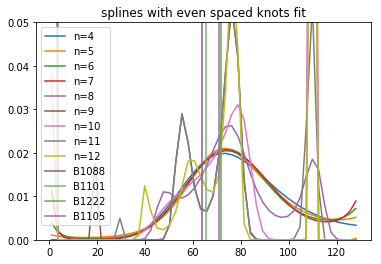

In [28]:
# NBVAL_SKIP
max_n = 12
_morph_derivative_spline_even = _viz_df_derivative_fits_maker(range(4, max_n + 1), p0_spline_even, f_spline_even, idx_label="n=%d")
_morph_derivative_spline_even(data=morph_dim_group)
plt.legend();
plt.ylim(0, .05);
plt.title("splines with even spaced knots fit");

### Single block fits

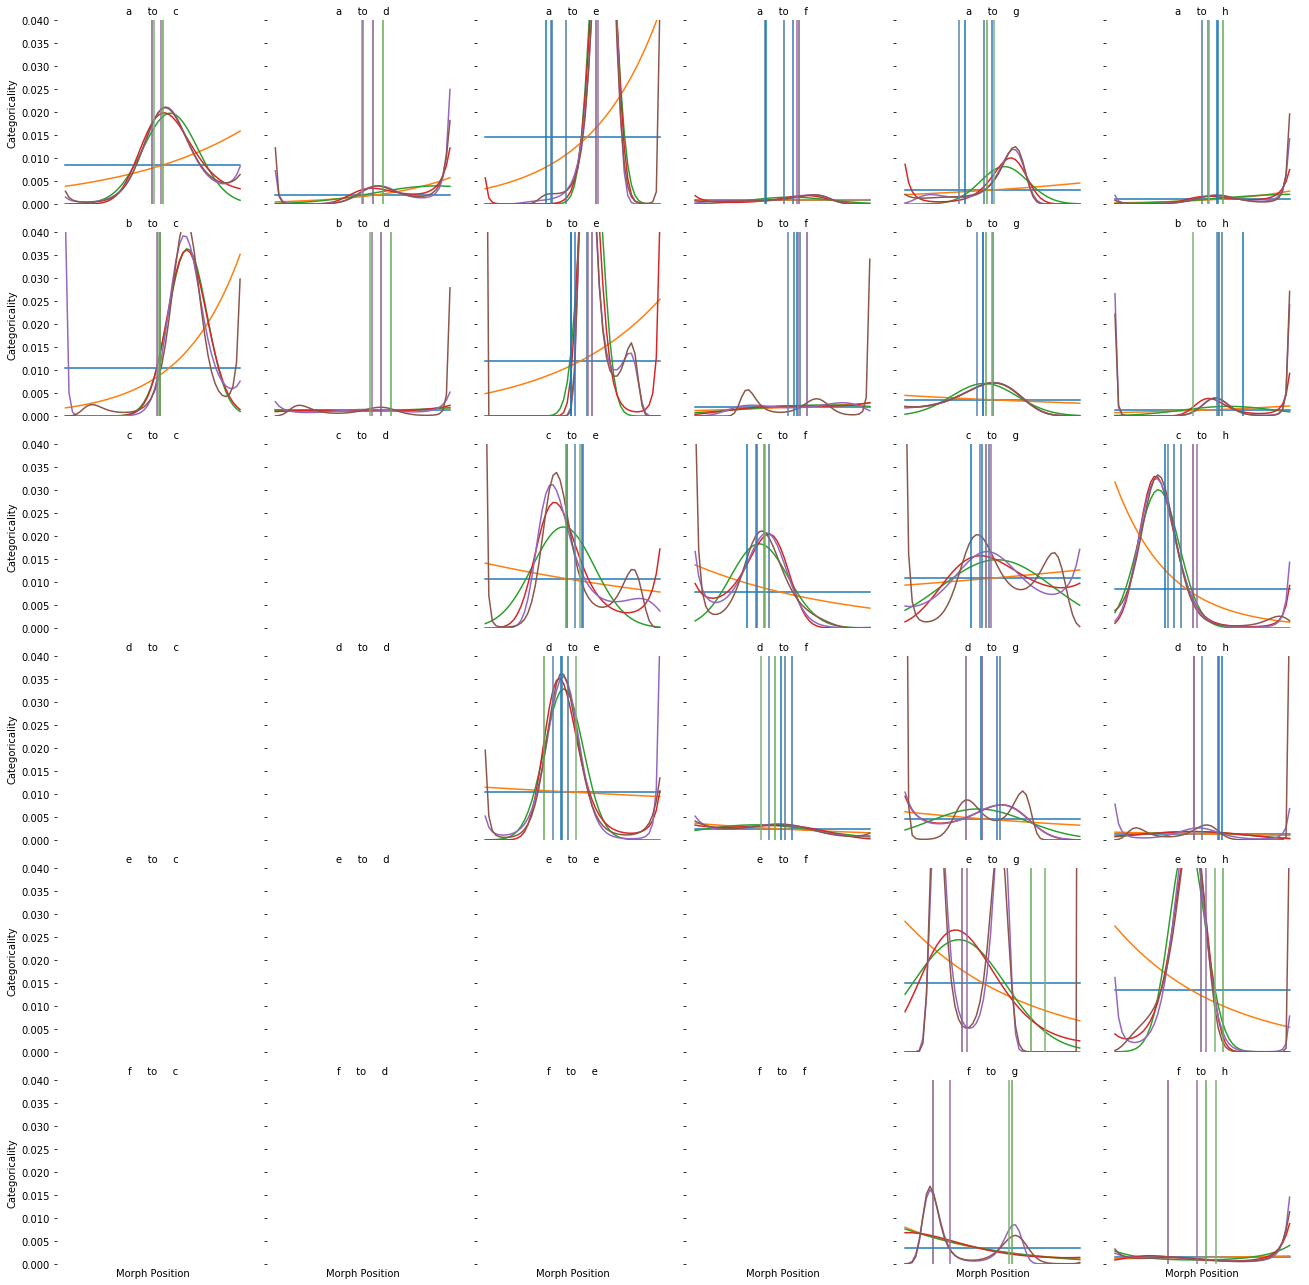

In [29]:
morph_derivative_ordered(block_group, title=morphs.data.parse.blockpath_name(block_path), max_order=5)

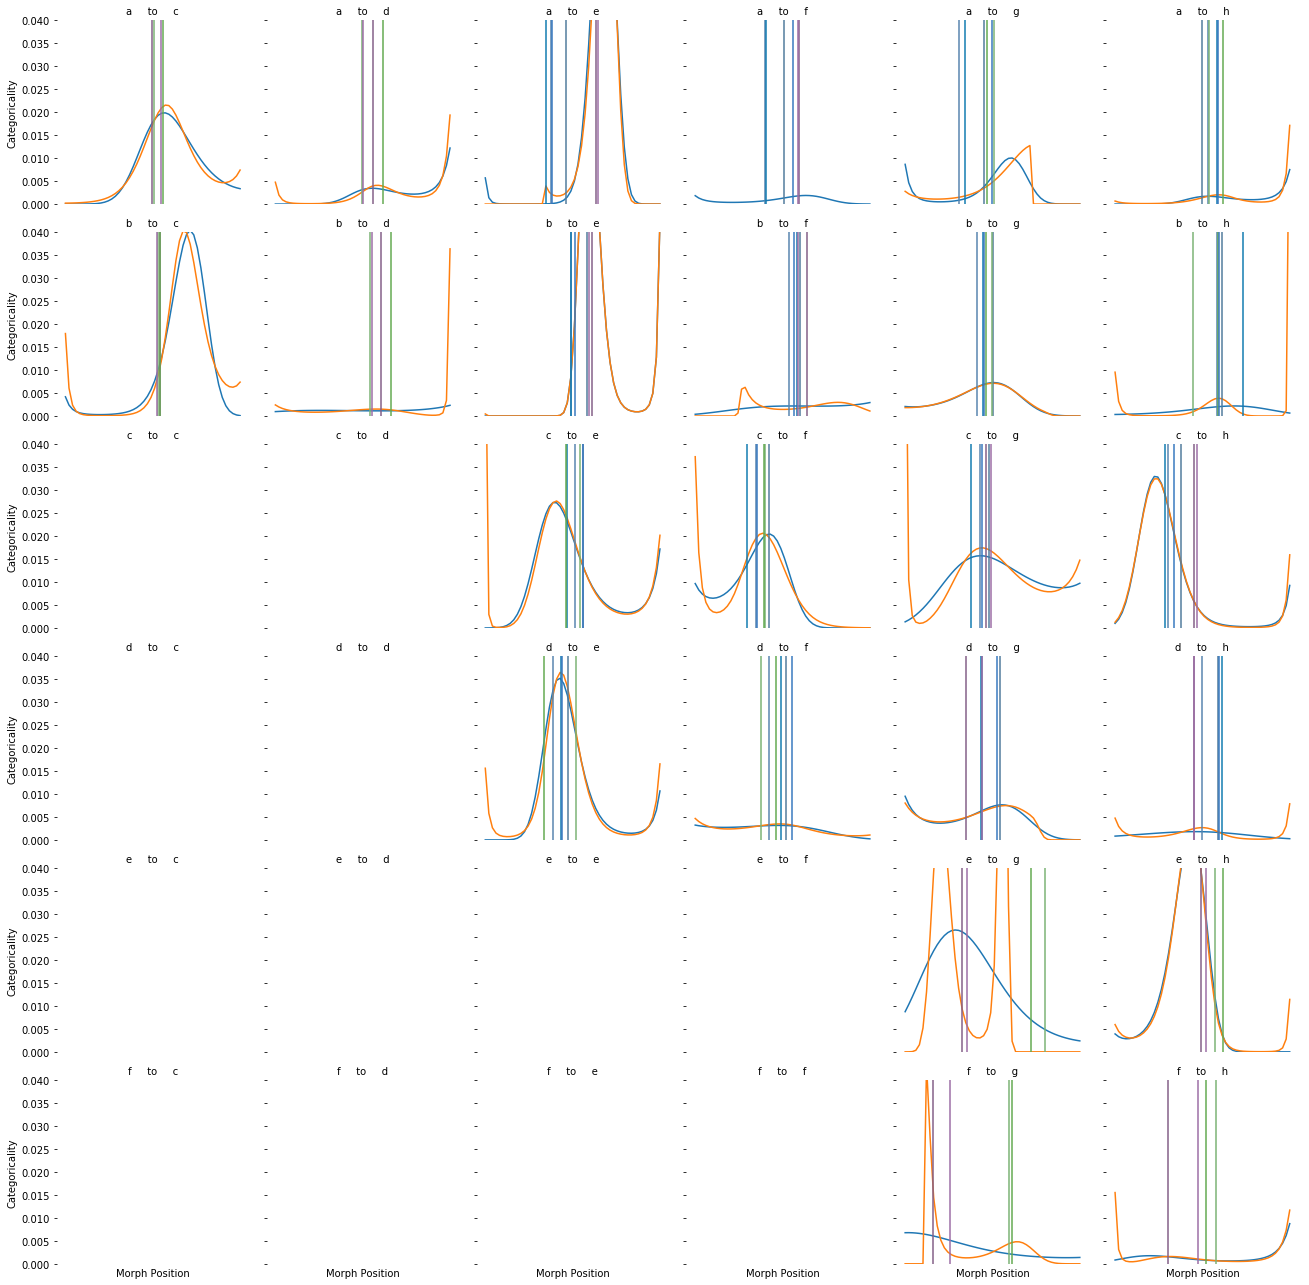

In [30]:
# NBVAL_SKIP
morph_derivative_spline_floating(block_group, title=morphs.data.parse.blockpath_name(block_path), max_f_knots=1)

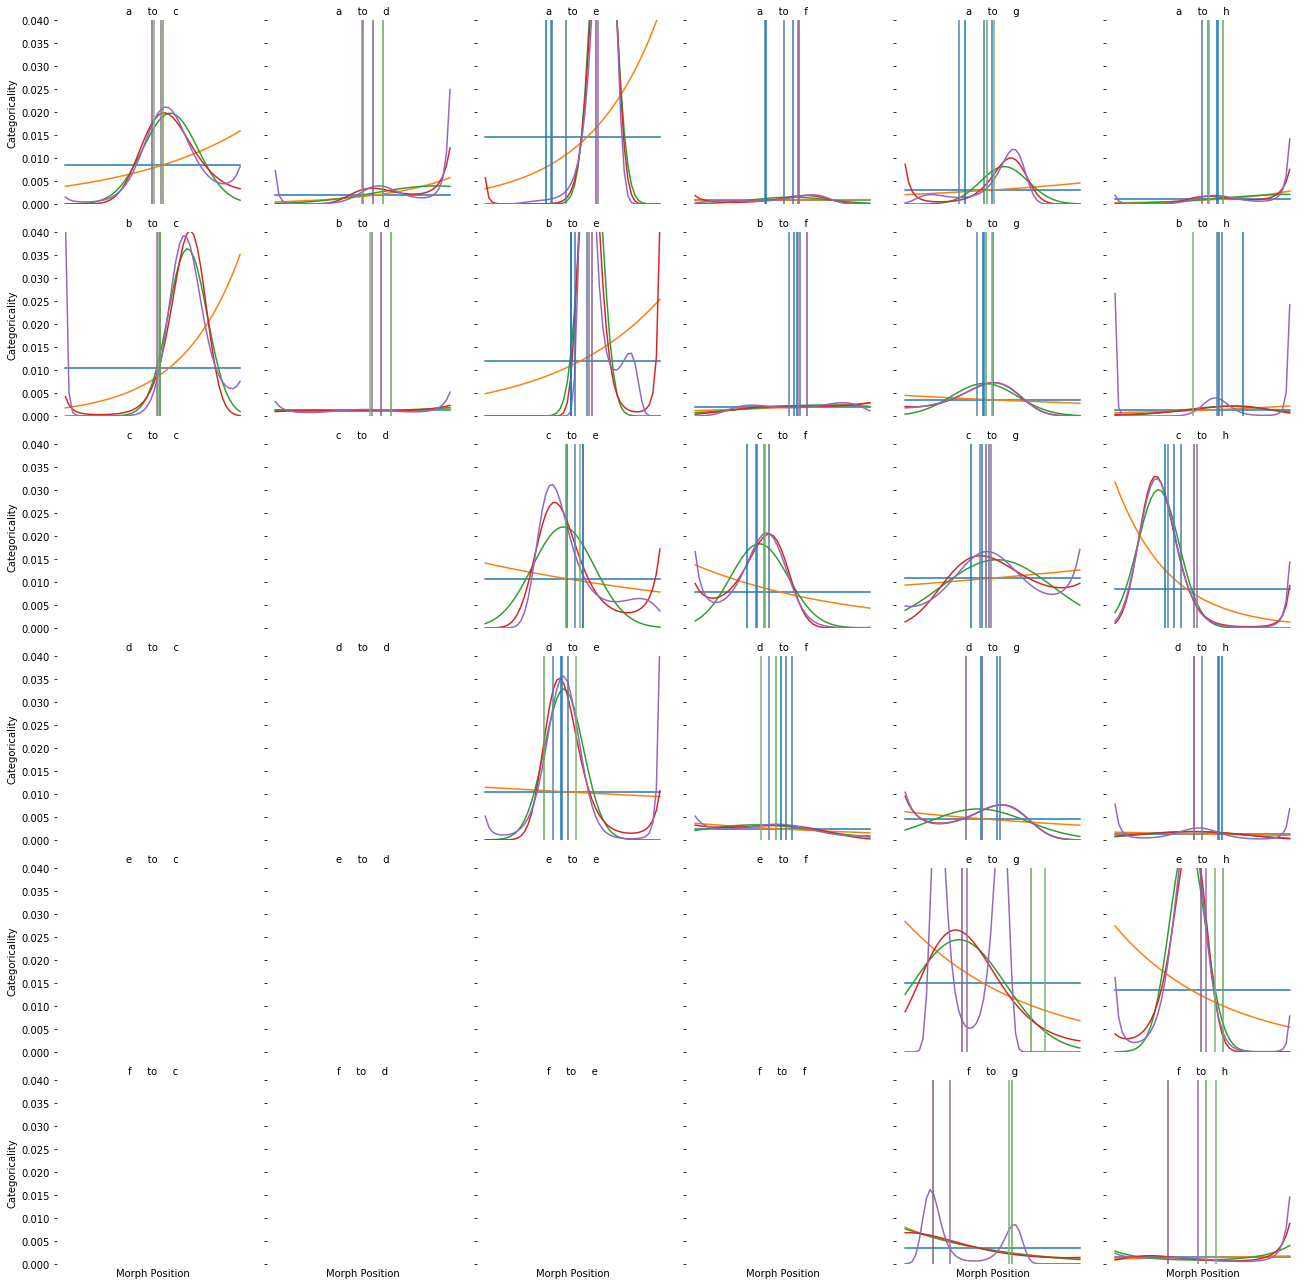

In [31]:
# NBVAL_SKIP
morph_derivative_spline_degree(block_group, title=morphs.data.parse.blockpath_name(block_path), max_degree=4)

### Decimated blocks fits

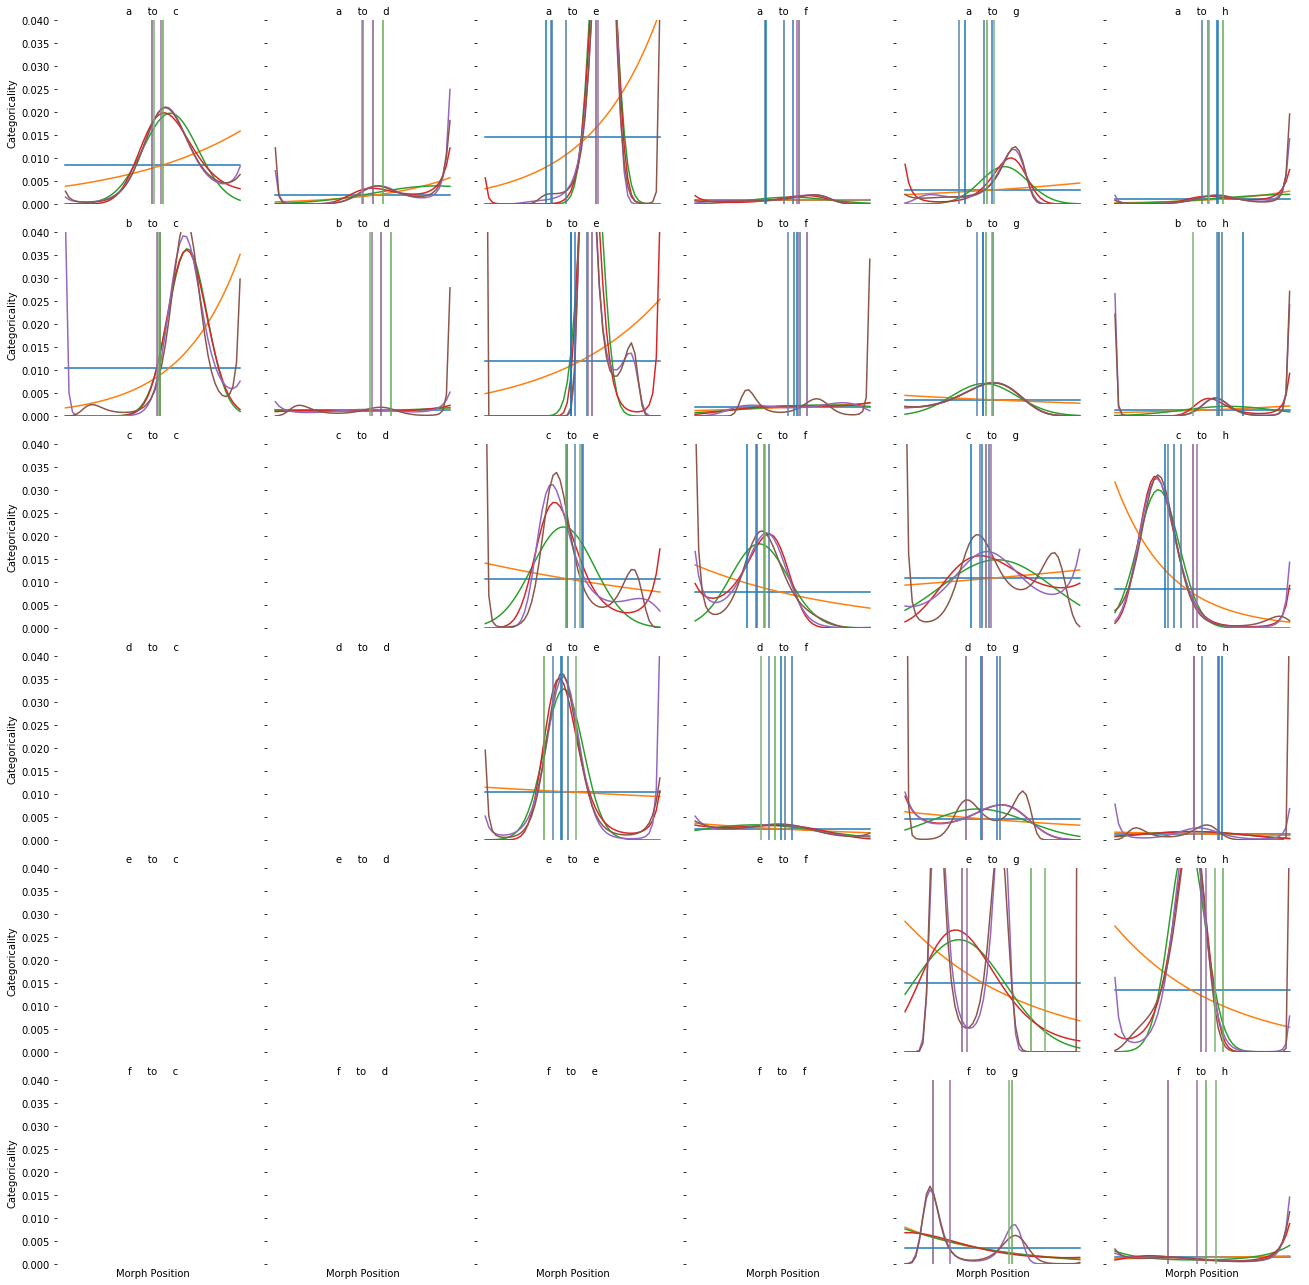

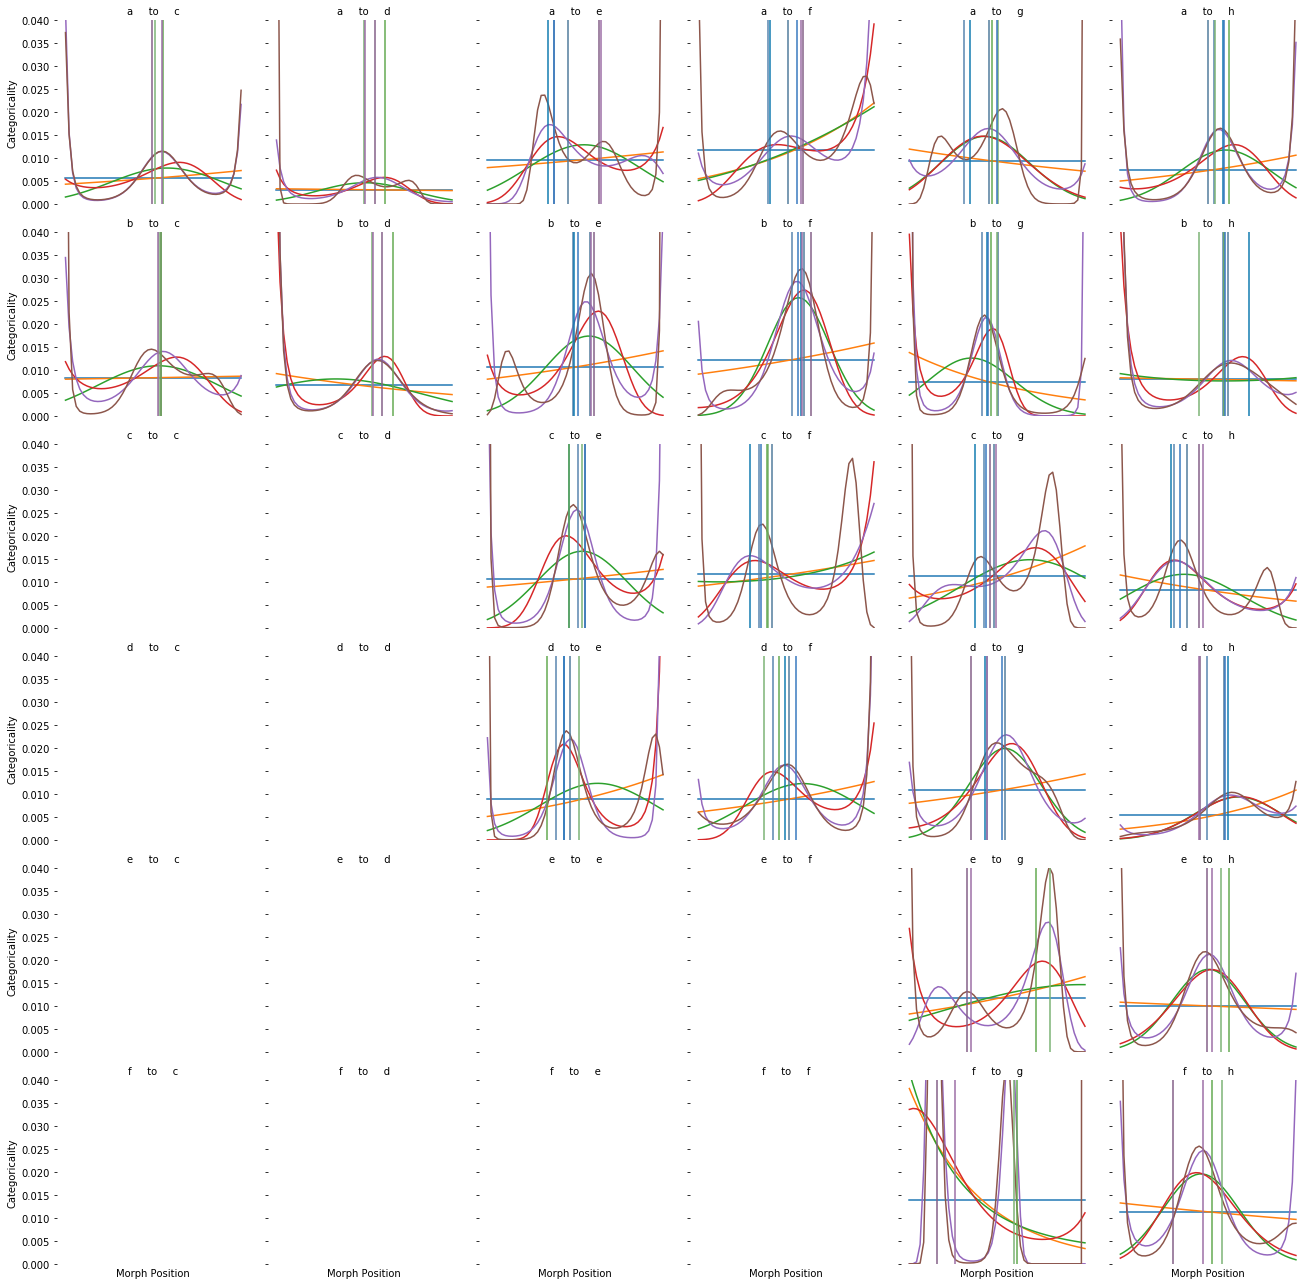

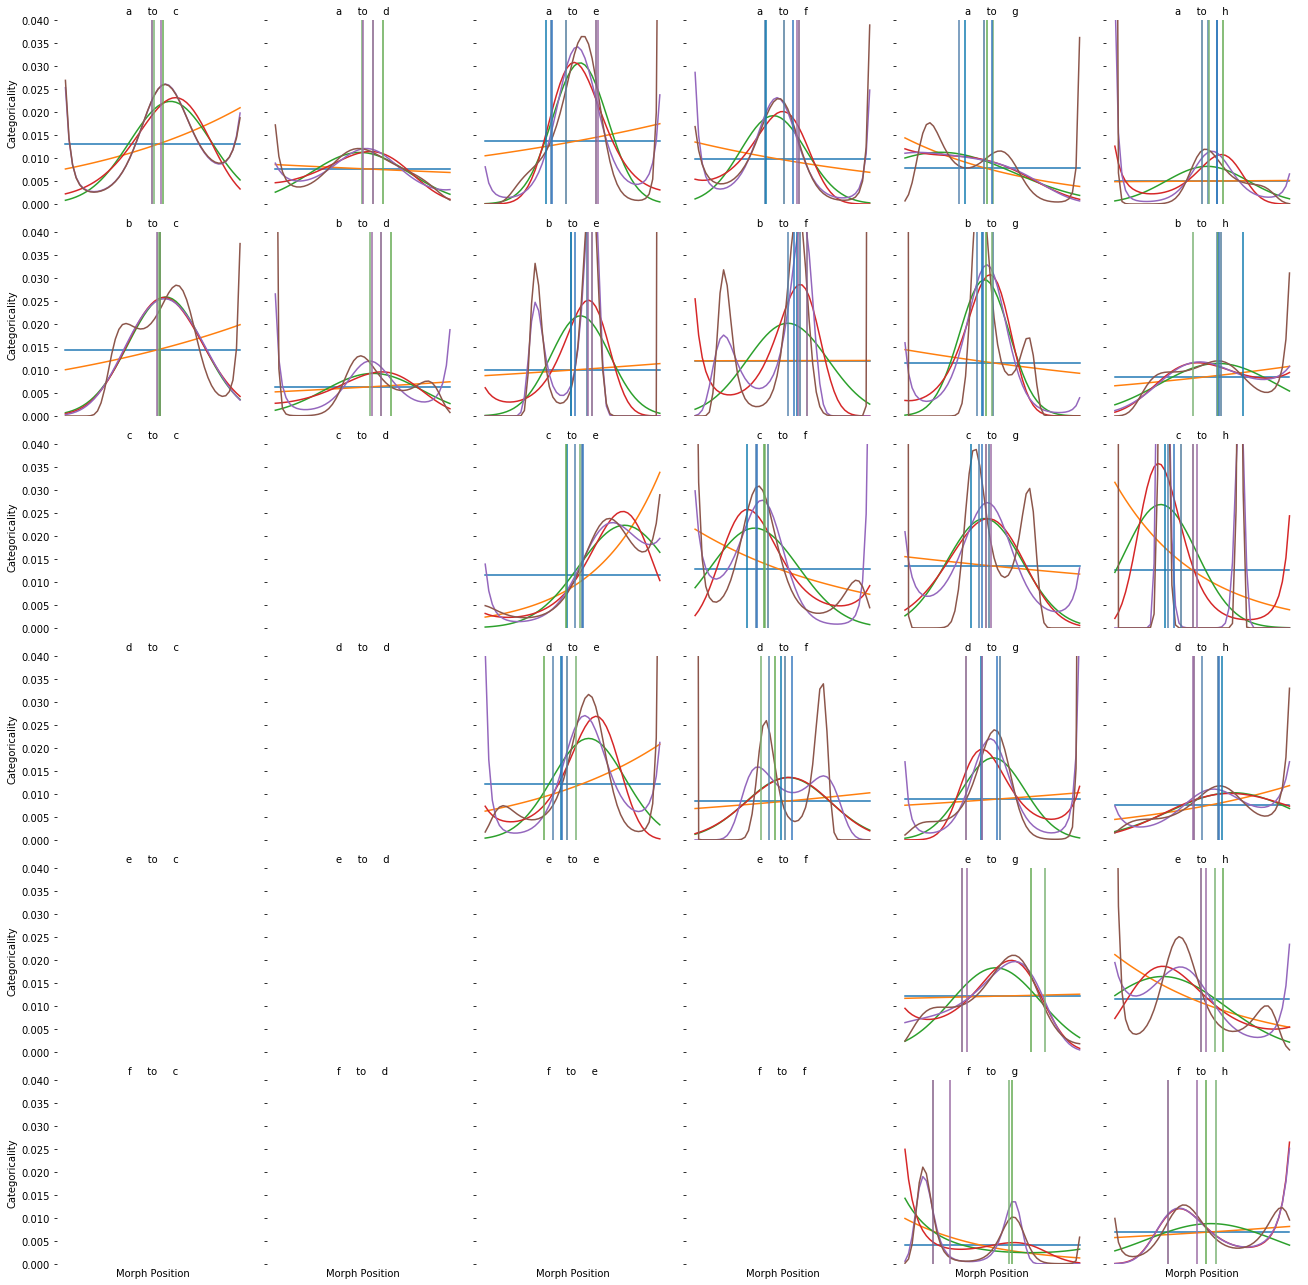

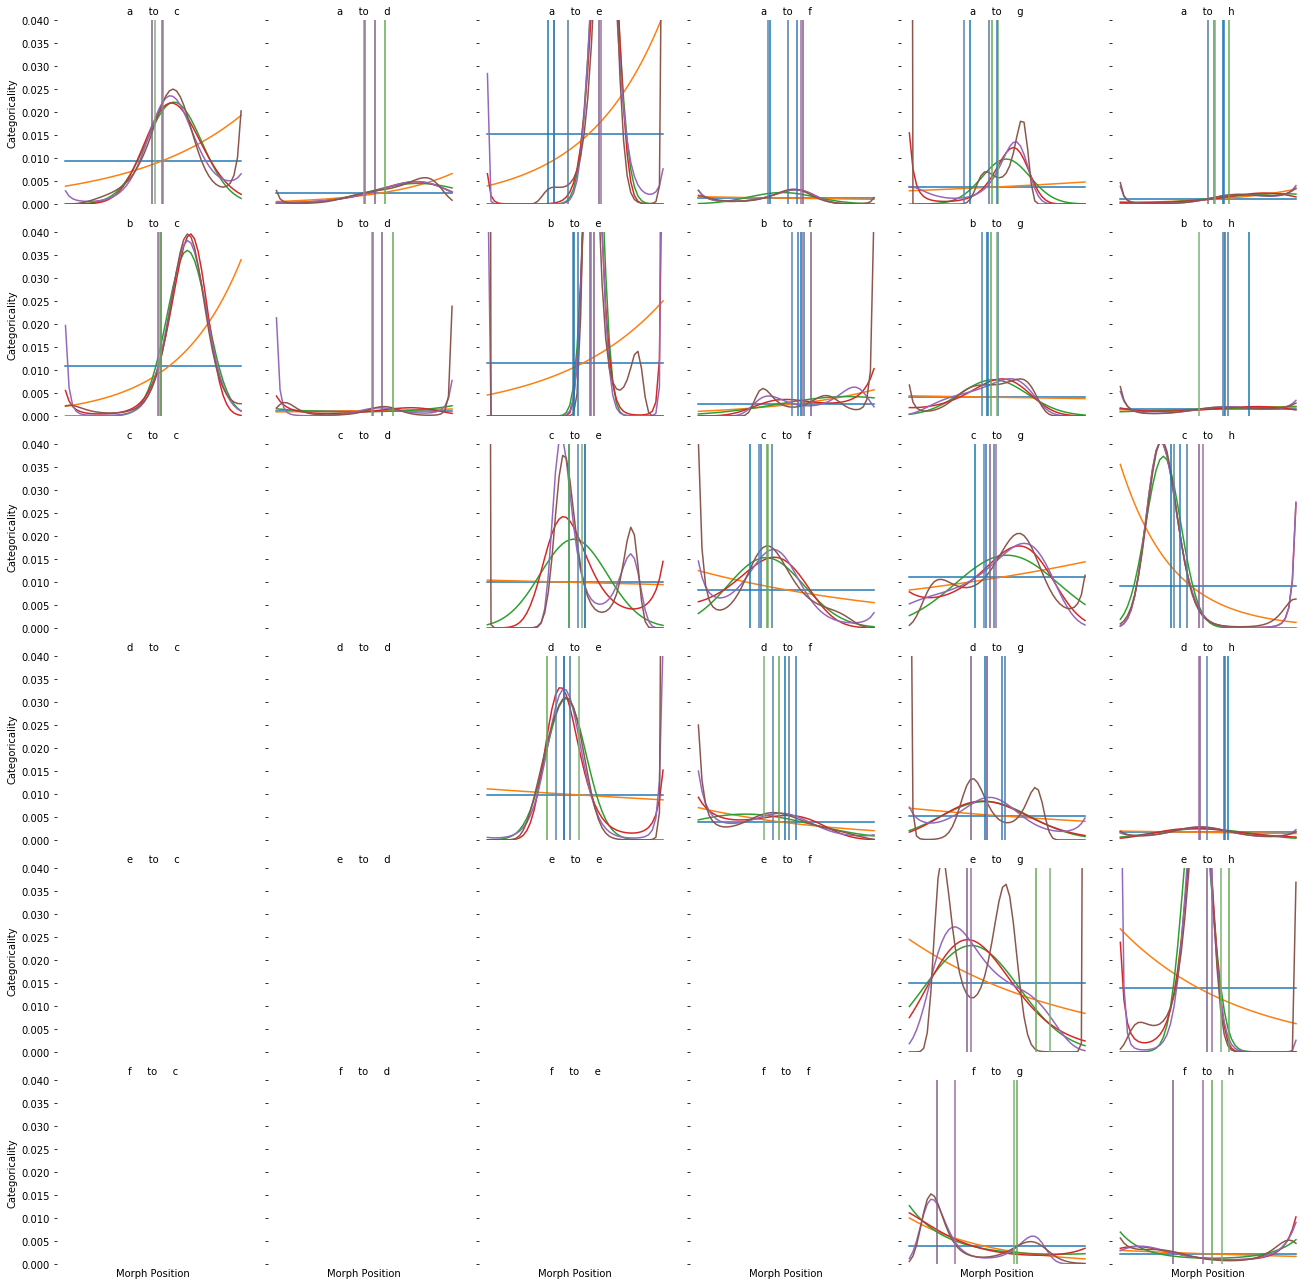

In [32]:
# NBVAL_SKIP
for i, (block_path, block_group) in enumerate(pair_df.groupby("block_path")):
    if i % 10 == 0:
        morph_derivative_ordered(block_group, title=morphs.data.parse.blockpath_name(block_path), max_order=5)